In [1]:
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Input
from keras.layers import Reshape, UpSampling2D
import powerlaw

import math, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pwl = powerlaw.Power_Law(xmin=1, discrete=True, parameters=[1.9])

Using TensorFlow backend.


In [2]:
def py(d = 0.1):
    """Something akin to a Pitman-Yor process"""
    members = []
    
    while True:
        if len(members) < 1 or random.random() < d:
            draw = random.normalvariate(0, 1.0)
        else:
            draw = random.choice(members)
            
        yield draw
        members.append(draw)

gen = py(0.01)

def py_init(shape, dtype=None):
    """Custom weight initializer for Keras""" 
    arr = np.fromfunction(lambda *args: args[0]*0.0 + next(gen), shape=shape)
    return arr
#     return K.random_normal(shape, dtype=dtype)

In [3]:
# Sample a model

# number of blocks of k convolutions and 
input_dim = int(pwl.generate_random()[0])
print('input_dim\t', input_dim)

num_channels = int(pwl.generate_random()[0])
print('num_channels\t', num_channels)

numblocks = random.randint(1,13) # this should be unbounded for a proper model class
print('numblocks\t', numblocks)

blockdepth = random.randint(1,7)
print('blockdepth\t', blockdepth)

kernelsize = random.randint(1,10)
print('kernelsize\t', kernelsize)



input_dim	 1
num_channels	 1
numblocks	 7
blockdepth	 4
kernelsize	 5


In [4]:
# Reset the PY weight generator
# gen=py(0.2)

encoded = Input(shape=(input_dim,))

x = Dense(256, activation='relu')(encoded)
x = Reshape((4,4,16))(x)

for n in range(numblocks):
    for b in range(blockdepth):
        x = Conv2D(num_channels, (kernelsize, kernelsize), activation='relu', padding='same', kernel_initializer=py_init)(x)
        
    x = UpSampling2D((2, 2))(x)
        
decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

decoder = Model(encoded, decoded)

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 1)           401       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 1)           26        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 1)           26        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 1)           26        
__________

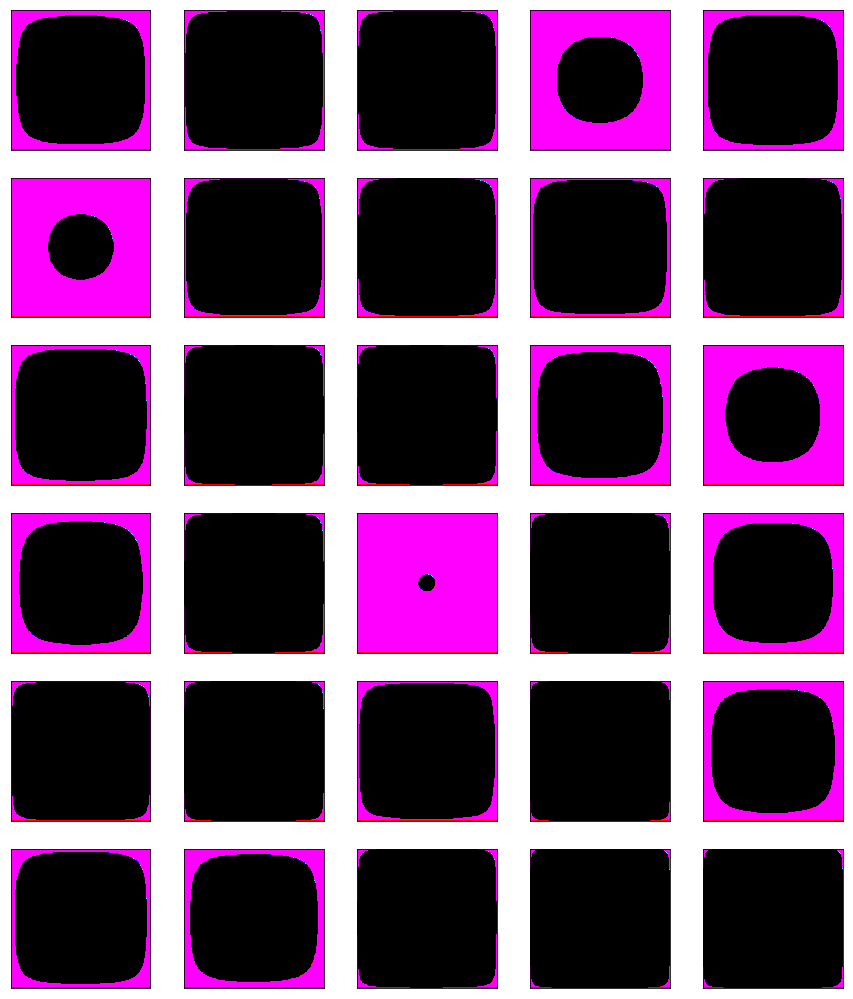

In [5]:
n = 30

z = np.random.randn(n, input_dim)
y = decoder.predict(z)

fig = plt.figure(figsize=(15, 18))
# plot several images
for i in range(n):
    ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(y[i,...], cmap=plt.cm.gray)
    
plt.savefig('random-images-2.pdf')